## Environment preparation

In [6]:
import sys
sys.path.append('../src')

import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from itertools import chain
import random
import vgg16
import data_helper
from data_helper import Preprocessor
from vgg16 import MyNet


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Let pandas to print full name of data contents, instead of 'blah...'
pd.set_option('display.max_colwidth', -1)

tf.__version__

# Data input
destination_path = "../input/"
is_datasets_present = True

datasets_path = data_helper.get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

if not is_datasets_present:
    print("Not all datasets are present.")
else:
    print("All datasets are present.")


All datasets are present.


## Loading data and trained weights

In [7]:
# Training and test data loading
train_jpeg_dir, test_jpeg_dir, train_csv_file, test_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
labels_df_test = pd.read_csv(test_csv_file)
labels_df_test.head()

,image_name,tags
0,test_32950,clear primary
1,test_1375,agriculture clear cultivation primary road
2,test_27825,clear primary water
3,test_37560,agriculture partly_cloudy primary road water
4,test_40495,partly_cloudy primary


There are 17 unique labels including {'habitation', 'artisinal_mine', 'blow_down', 'cloudy', 'slash_burn', 'clear', 'blooming', 'haze', 'selective_logging', 'road', 'primary', 'agriculture', 'partly_cloudy', 'cultivation', 'bare_ground', 'water', 'conventional_mine'}
0 train_4.jpg habitation agriculture clear habitation primary road
1 train_185.jpg artisinal_mine agriculture artisinal_mine clear cultivation habitation primary road water
2 train_535.jpg blow_down blow_down clear primary
3 train_22.jpg cloudy partly_cloudy primary
4 train_728.jpg slash_burn agriculture clear cultivation habitation primary road slash_burn
5 train_8.jpg clear agriculture clear cultivation primary
6 train_519.jpg blooming blooming clear primary
7 train_133.jpg haze haze primary
8 train_746.jpg selective_logging clear primary road selective_logging
9 train_58.jpg road agriculture clear primary road
10 train_10.jpg primary agriculture clear primary slash_burn water
11 train_33.jpg agriculture agriculture cult

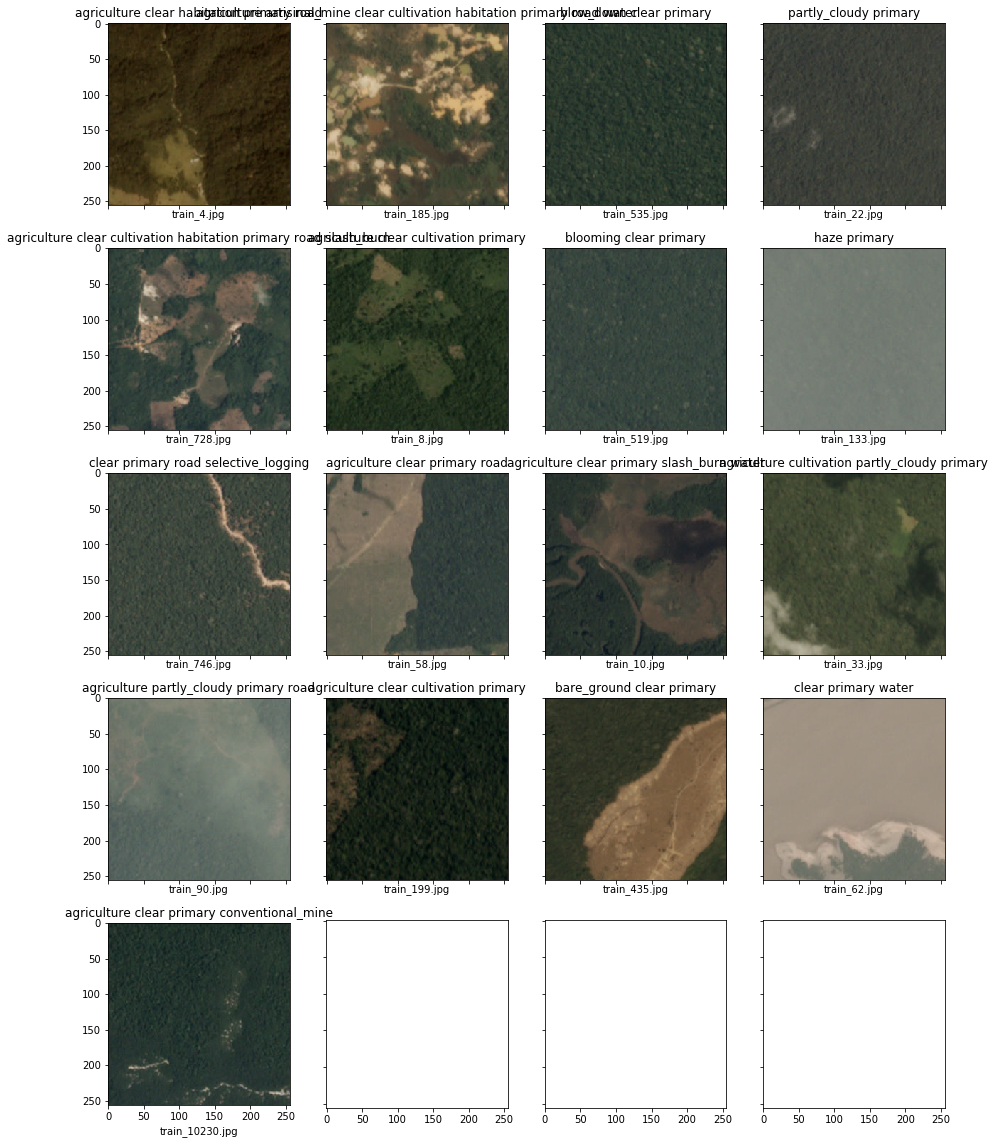

In [9]:
# Brief look at data
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There are {} unique labels including {}".format(len(labels_set), labels_set))

images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

labels_dict = dict()
for fn,tags in labels_df.values:
    labels_dict[fn] = tags
    
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)

    
    labels=labels_dict[image_name[:-4]]
    print(i, image_name, label, labels)
    axs[i].imshow(img)
    axs[i].set_title('{}'.format(labels))
    axs[i].set_xlabel('{}'.format(image_name))
plt.show()


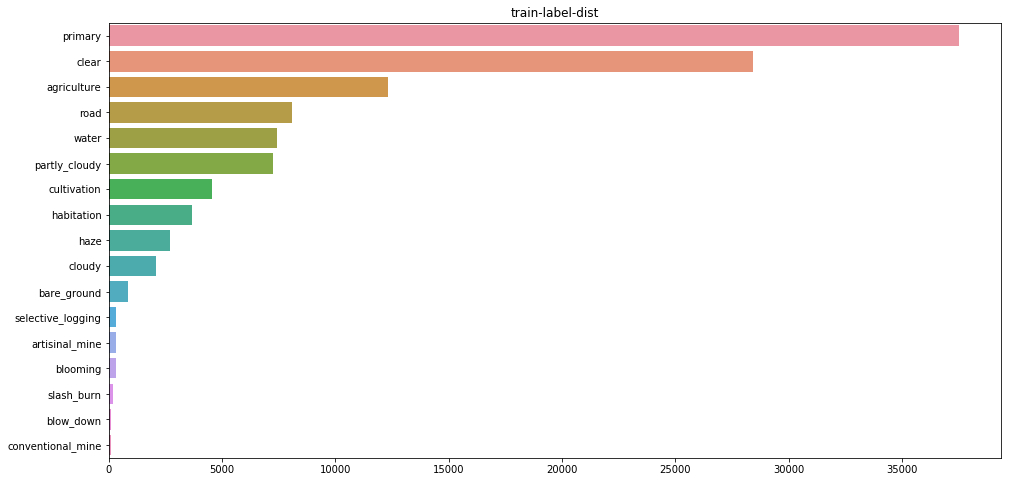

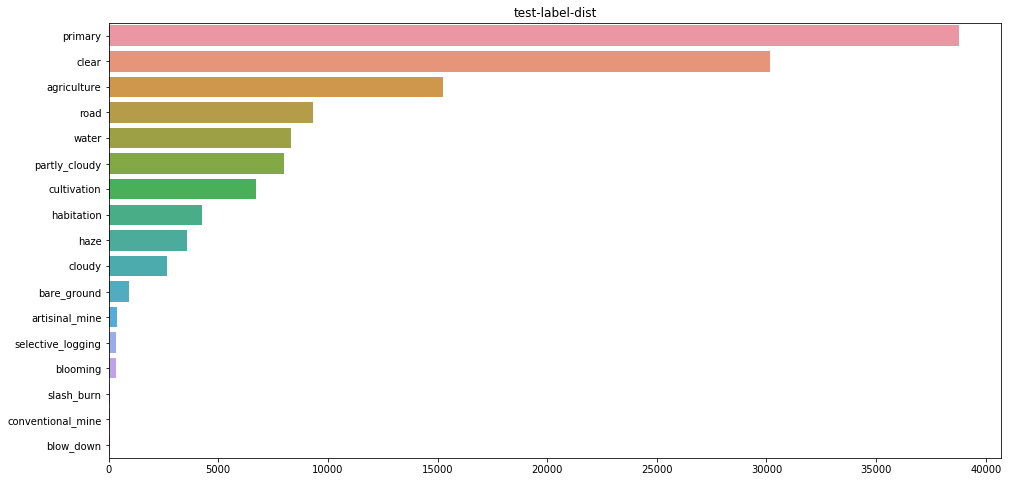

In [10]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from collections import Counter, defaultdict
    
# Histogram of labeled data: train/test
labels = [labels_df['tags'].apply(lambda x: x.split(' ')),
          labels_df_test['tags'].apply(lambda x: x.split(' '))]
dist_titles = ['Distribution of training labels', 'Distribution of testing labels']
cooccur_titles = ['Co-occurence matrix of training labels', 'Co-occurence matrix of testing labels']
dist_fns = ['train-label-dist', 'test-label-dist']
cooccur_fns = ['train-cooccur-matrix', 'test-cooccur-matrix']

for idx in [0,1]: # Train vs. test

    counts = defaultdict(int)
    for l in sorted(labels[idx]):
        for l2 in l:
            counts[l2] += 1

#    data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
#    layout=dict(height=800, width=800, title=dist_titles[idx])
#    fig=dict(data=data, layout=layout)
#    py.iplot(fig, filename=dist_fns[idx])

    tags_s = pd.Series(list(chain.from_iterable(labels[idx]))).value_counts()
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=tags_s, y=tags_s.index, orient='h');
    plt.title(dist_fns[idx])
    plt.show()

    # Co-occurrence Matrix 
    com = np.zeros([len(counts)]*2)
    for i, l in enumerate(list(counts.keys())):
        for i2, l2 in enumerate(list(counts.keys())):
            c = 0
            cy = 0
            for row in sorted(labels[idx].values):
                if l in row:
                    c += 1
                    if l2 in row: cy += 1
            com[i, i2] = cy / c

    data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
    layout=go.Layout(height=800, width=800, title=cooccur_titles[idx])
    fig=dict(data=data, layout=layout)
    py.iplot(fig, filename=cooccur_fns[idx])



In [11]:
img_resize = (256, 256, 3)

# Split data into train/validation - percentage setting
validation_split_size = 0.2

# Data preprocessing
preprocessor = Preprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_csv_file,
                            img_resize[:2], validation_split_size)
preprocessor.init()

print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/y_test length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.y_test)))
preprocessor.y_map


100%|██████████| 40669/40669 [00:00<00:00, 227578.63it/s]

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/y_test length: 40669/40669


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

## Construct the model

In [12]:
# Constructing the model
#----------------------------

mynet = MyNet(img_dim=img_resize)
mynet.model.summary()
mynet.model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])


X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 32
train_steps = len(X_train) / batch_size
val_steps = len(X_val) / batch_size

train_generator = preprocessor.get_train_generator(batch_size)
val_generator = preprocessor.get_val_generator(batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                557073    
Total params: 15,271,773
Trainable params: 15,271,767
Non-trainable params: 6
_________________________________________________________________


In [ ]:
# Train the model
#----------------------------

history = History()
callbacks = [history,
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto')]

# No serious training running on Jupyter notebooks, Run EPOCH
history = mynet.model.fit_generator(train_generator, train_steps, epochs=1, verbose=1,
                    validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)


# ## Visualize Loss Curve

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig("vgg16.losses.png")



In [13]:
# Loading trained weights
mynet.model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")


Weights loaded


   ## Train the model

## Evaluate

In [14]:
predictions, x_test = mynet.predict(preprocessor, batch_size=32)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                    x_test.shape, x_test[0], predictions[0]))

# Setting threshold for each class
thresholds = [0.2] * len(labels_set)

predicted_labels = mynet.map_predictions(preprocessor, predictions, thresholds)


1271/1270 [==============================] - 240s 189ms/step
Predictions shape: (40669, 17)
Files name shape: (40669,)
1st predictions (/work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_32950.jpg) entry:
[9.98236895e-01 2.56119984e-05 9.13872477e-03 7.25241844e-05
 2.75796574e-05 9.78744328e-01 1.97298178e-08 5.80347523e-06
 5.85566819e-01 7.59468153e-02 1.29144415e-02 7.40861474e-03
 9.99977231e-01 1.75759315e-01 4.43926074e-05 8.39924533e-03
 1.84377637e-02]


### Peep into predictions

0 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_14703.jpg ['agriculture', 'clear', 'cultivation', 'habitation', 'primary', 'road', 'water'] clear primary
1 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_28903.jpg ['clear', 'primary'] clear primary
2 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_14078.jpg ['clear', 'primary'] blooming clear primary
3 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_22844.jpg ['artisinal_mine', 'bare_ground', 'clear', 'cultivation', 'primary', 'road', 'water'] clear primary
4 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_20957.jpg ['clear', 'primary'] agriculture partly_cloudy primary road
5 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_28441.jpg ['agriculture', 'clear', 'habitation', 'primary', 'road'] clear primary
6 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_34064.jpg ['clear', 'primary'] cloudy
7 /work/git_repo/amazon_challenge/mlc.ka

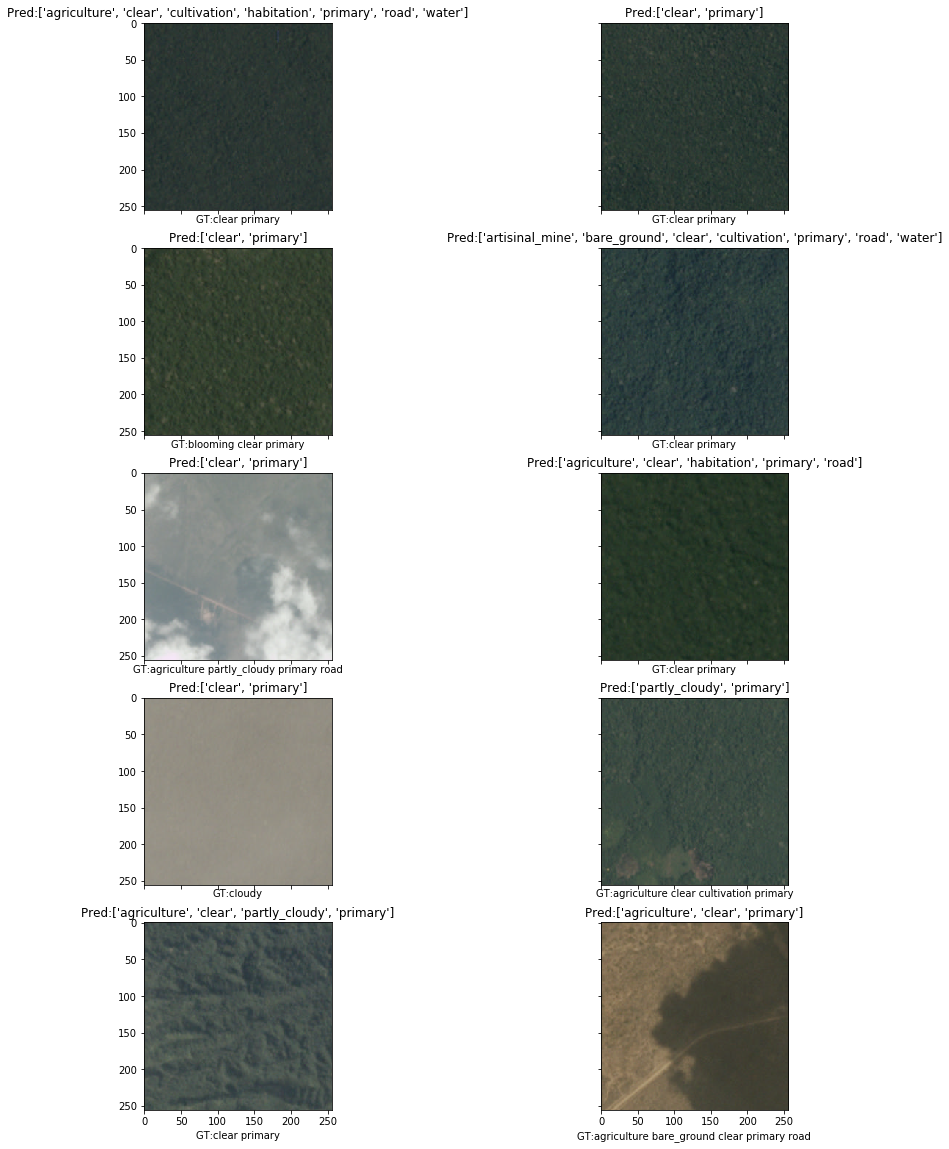

In [15]:
import re

# Look at predicted_labels vs. GT
###################################
# NO REAL GROUND TRUTH exists!!!
# Kaggle doesn't provide GT for test data.
# Used some fake ones instead. 
###################################
labels_dict_test = dict()
for fn,tags in labels_df_test.values:
    labels_dict_test[fn] = tags
    
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 2, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for j in range(10):
    i = random.randint(0, len(predicted_labels))
    img = mpimg.imread(x_test[i])
    
    x_test_stripped = ''
    matchObj = re.match( r'.*(test_\d*).jpg.*', x_test[i])
    x_test_stripped = matchObj.group(1)

    labels=labels_dict_test[x_test_stripped]
    print(j, x_test[i], predicted_labels[i], labels)
    axs[j].imshow(img)
    axs[j].set_title('Pred:{}'.format(predicted_labels[i]))
    axs[j].set_xlabel('GT:{}'.format(labels))
plt.show()

In [16]:
import psutil

batch_size=32
print("model metrics_name:", mynet.model.metrics_names)
my_loss, my_metric = mynet.model.evaluate_generator(preprocessor._get_prediction_generator(batch_size),
                         len(preprocessor.X_test) / batch_size, workers = (psutil.cpu_count()-1))
print("my_loss=", my_loss, "my_metric=", my_metric)


model metrics_name: ['loss', 'acc']
my_loss= 0.06183087069642618 my_metric= 0.9712137823193498


In [20]:
fbeta_score = mynet.fbeta(preprocessor, mode=1)
print("fbeta_score (training data) = ", fbeta_score)

1012/1011 [==============================] - 462s 457ms/step
fbeta_score (training data) =  0.5889056270283823


In [17]:
# TODO: No thresholding applied yet! Use 0.2 as default.
fbeta_score = mynet.fbeta(preprocessor, mode=2)
print("fbeta_score (validation data) = ", fbeta_score)

253/253 [==============================] - 47s 187ms/step
fbeta_score (validation data) =  0.587315073503976


In [18]:
##----------------------------------------
## TEST data score is expected to be low, as there NO REAL GROUND TRUTH!!!
##----------------------------------------
fbeta_score = mynet.fbeta(preprocessor)
print("fbeta_score (test data) = ", fbeta_score)

1271/1270 [==============================] - 240s 189ms/step
fbeta_score (test data) =  0.5910297964737898


In [19]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test, tags_list)]


final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()


final_df.to_csv('../submission_file.csv', index=False)

Predictions rows: 81338
